![timeseries1](timeseries1.jpg)

# Table of contents
1. [Objective](#obj)
2. [Data Loading and Visualiztion](#datadoading)
3. [Decomposition](#Decomposition) 
4. [Stationarity Check](#StationarityCheck)<br>
    4.1. [Rolling Statistics Methodology](#RollingStatisticsMethodology)<br>
    4.2. [ADF(Augmented Dickey-Fuller)Test](#ADF)<br>
5. [Data Transformation to achieve Stationarity](#DataTransformationStationarity)<br>
    5.1. [Log Scale Transformation](#LogScaleTransformation)<br>
    5.2. [Log Scale - Moving Average Transformation](#MovingAverageTransformation)<br>
    5.3. [Exponential Decay Transformation](#ExponentialDecayTransformation)<br>
    5.4. [Time Shift Transformation](#TimeShiftTransformation)<br>
6. [Plotting ACF & PACF](#PlottingACF&PACF)
7. [Building Models](#BuildingModels)<br>
    7.1 [AR Model](#ARModel)<br>
    7.2 [ARMA Model](#ARMAModel)<br>
    7.3 [ARIMA Model](#ARIMAModel)<br>
8. [Prediction & Reverse transformations of fittedvalues](#Prediction&ReverseTransformations)
9. [Conclusion](#con)


<a id= obj> </a>
## 1.0 Objective

- The objective of this project is to predict 3 months of item-level sales data at different store locations.

### Data fields description
-	date - Date of the sale data. There are no holiday effects or store closures.
-	store - Store ID
-	item - Item ID
-	sales - Number of items sold at a particular store on a particular date.


<a id= datadoading> </a>
## 2.0 Data Loading and Visualization
- Import data set

In [1]:
import pandas as pd  
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
storedata  =  pd.read_csv('https://raw.githubusercontent.com/insaid2018/Term-3/master/Projects/Store_Item_demand_forecast.csv')
storedata.head(5)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


- This is a Times series data and it deals with __4 columns__ 
- one field has date,store id, item value & another is the value to be forecasted ie: __Sales.__
- To make plotting graphs easier, we set __date__ as the index of pandas dataframe as during plots

In [2]:
storedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
date     913000 non-null object
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [154]:
# Checking how many Unique values 
print('Unique items id:',storedata['item'].unique())
print('Unique store id:',storedata['store'].unique())

Unique items id: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
Unique store id: [ 1  2  3  4  5  6  7  8  9 10]


In [119]:
from datetime import datetime

storedata['date']  =  pd.to_datetime(storedata['date'],infer_datetime_format = True) #convert from string to datetime
indexedset  =  storedata.set_index(['date'])[:50000]
indexedset.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


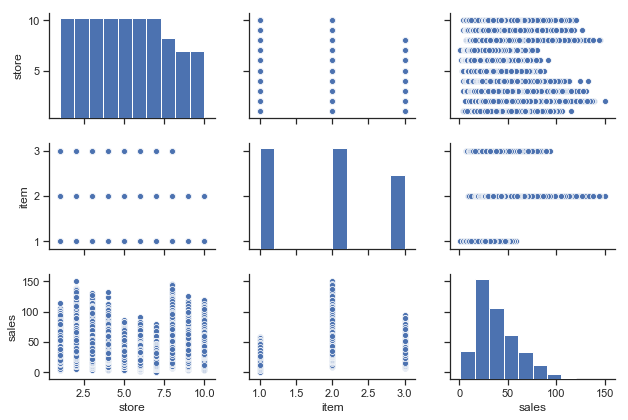

In [120]:
#Checking correlation across different fields
import seaborn as sns; sns.set(style="ticks", color_codes=True)
sns.pairplot(indexedset, height = 2, aspect = 1.5)

In [7]:
indexedset.isnull().sum()

store    0
item     0
sales    0
dtype: int64

In [8]:
indexedset.shape

(50000, 3)

In [7]:
indexedset.isna().sum()

store    0
item     0
sales    0
dtype: int64

D:\Sathish\Anaconda\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


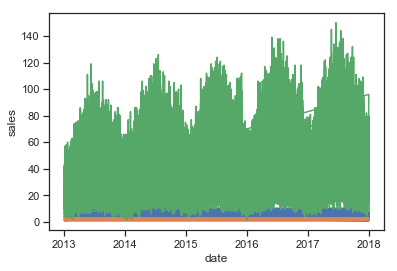

In [9]:
import matplotlib.pylab as plt 
%matplotlib inline                        

plt.xlabel('date')
plt.ylabel('sales')
plt.plot(indexedset)

- We can see a Trend in the Sales data set

<a id= Decomposition> </a>
### 3. Decomposition

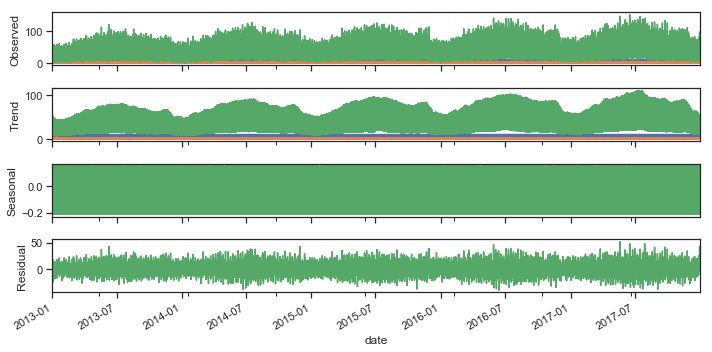

In [10]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']  =  10, 5

from statsmodels.tsa.seasonal import seasonal_decompose

decomposed_dataset  =  seasonal_decompose(indexedset,freq=20)         
figure  =  decomposed_dataset.plot()
plt.show()

- We can see trend with the __sales data __
- We are not able to observe any __seasonal__ peaks in the __Sales data__

<a id= StationarityCheck> </a>
### 4.0 Stationary Check

In [12]:
 def test_stationarity(time_series):
    rolling_means(indexedset['sales'].iloc[:50000])
    adf_test(indexedset['sales'].iloc[:50000])

<a id= RollingStatisticsMethodology> </a>
#### 4.1 Rolling Statistics Methodology

In [161]:
# Determine rolling statistics
def rolling_means(time_series):
    rolmean  =  time_series.rolling(window = 3).mean()    #window size 12 denotes 12 months, giving rolling mean at yearly level
    rolstd  =  time_series.rolling(window = 3).std()

    #Plot rolling statistics

    rcParams['figure.figsize']  =  10, 5 

    orig  =  plt.plot(time_series, color = 'blue', label = 'Original')
    mean  =  plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std  =  plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)

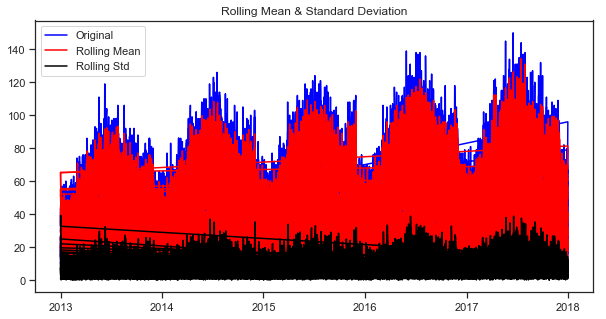

In [162]:
rolling_means(indexedset['sales'].iloc[:50000])

- Rolling mean has a trend component
- Rolling standard deviation is fairly constant with time.
- For our time series to be stationary, we need to ensure that both the rolling statistics i.e: mean & stdandard deviation remain time invariant or constant with time. Thus the curves for both of them have to be parallel to the x-axis, which in our case is not so.

- To further augment our hypothesis that the time series is not stationary, let us perform the __ADF test__

<a id= ADF> </a>
#### 4.2 ADF(Augmented Dickey-Fuller) Test

- For a Time series to be stationary, its ADF test should have:

- low p-value (according to the null hypothesis)
- Critical values at 1%, 5%, 10% confidence intervals should be as close as possible to the Test Statistics

In [163]:
#Perform Augmented Dickey–Fuller test:
def adf_test(time_series):
    from statsmodels.tsa.stattools import adfuller
    dftest  =  adfuller(time_series,autolag = 't-stat')

    dfoutput  =  pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]  =  value
    
    print('Results of Dickey Fuller Test:')    
    print(dfoutput)  
    

In [164]:
adf_test(adf_test(indexedset['sales'].iloc[:50000]))

Results of Dickey Fuller Test:
Test Statistic                -7.585445e+00
p-value                        2.614162e-11
#Lags Used                     5.700000e+01
Number of Observations Used    4.994200e+04
Critical Value (1%)           -3.430481e+00
Critical Value (5%)           -2.861598e+00
Critical Value (10%)          -2.566801e+00
dtype: float64


IndexError: tuple index out of range

- p-value & Test statistic value has lot of variation
- Also critical values (1%, 5%, 10%) are __no where close to__ the Test Statistics.
- Time series is not stationary 


<a id= DataTransformationStationarity> </a>
### 5. Data Transformation to achieve Stationarity

- We can try to achive stationary using different methods like __log scale, moving average,Exponential decay transformation,Time shift transformation.__

<a id= LogScaleTransformation> </a>
#### 5.1 Log Scale Transformation

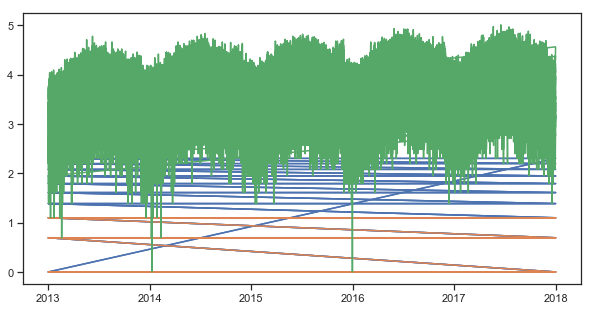

In [165]:
import numpy as np
np.seterr(divide = 'ignore')
indexedset_logScale  =  np.log(indexedset)
rcParams['figure.figsize']  =  10, 5
plt.plot(indexedset_logScale)

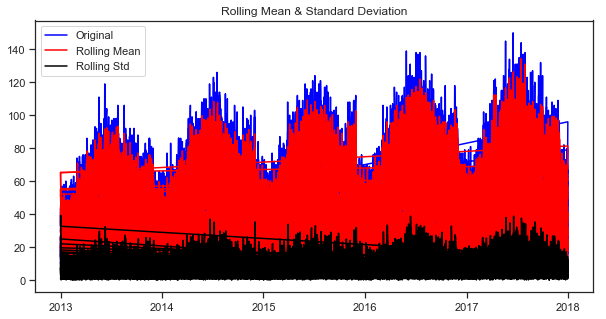

Results of Dickey Fuller Test:
Test Statistic                -7.585445e+00
p-value                        2.614162e-11
#Lags Used                     5.700000e+01
Number of Observations Used    4.994200e+04
Critical Value (1%)           -3.430481e+00
Critical Value (5%)           -2.861598e+00
Critical Value (10%)          -2.566801e+00
dtype: float64


In [166]:
test_stationarity(indexedset_logScale)

<a id= MovingAverageTransformation> </a>
#### 5.2 Log Scale - Moving Average Transformation

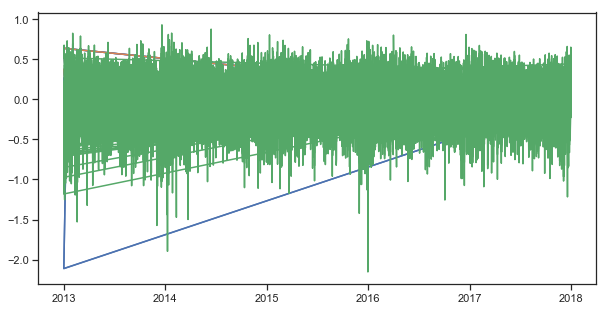

In [41]:
movingAverage  =  indexedset_logScale.rolling(window = 12).mean()
#print('MovingAverage :',movingAverage)
datasetLogScaleMinusMovingAverage  =  indexedset_logScale - movingAverage
#print('DatasetLogScaleMinusMovingAverage :',datasetLogScaleMinusMovingAverage)
plt.rcParams['agg.path.chunksize'] = 10000
plt.plot(datasetLogScaleMinusMovingAverage)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace = True)


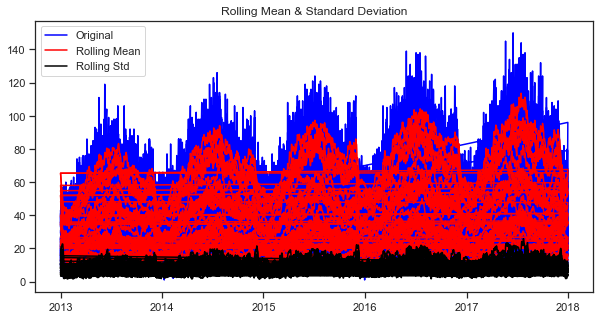

Results of Dickey Fuller Test:
Test Statistic                -7.585445e+00
p-value                        2.614162e-11
#Lags Used                     5.700000e+01
Number of Observations Used    4.994200e+04
Critical Value (1%)           -3.430481e+00
Critical Value (5%)           -2.861598e+00
Critical Value (10%)          -2.566801e+00
dtype: float64


In [42]:
test_stationarity(datasetLogScaleMinusMovingAverage)

<a id= ExponentialDecayTransformation > </a>
#### 5.3 Exponential Decay Transformation  

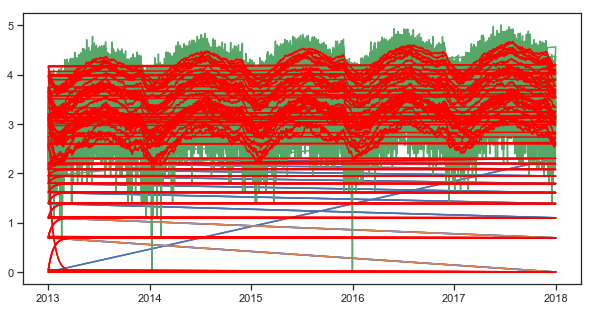

In [43]:
exponentialDecayWeightedAverage  =  indexedset_logScale.ewm(halflife = 12, min_periods = 0, adjust = True).mean()
plt.plot(indexedset_logScale)
plt.plot(exponentialDecayWeightedAverage, color = 'red')

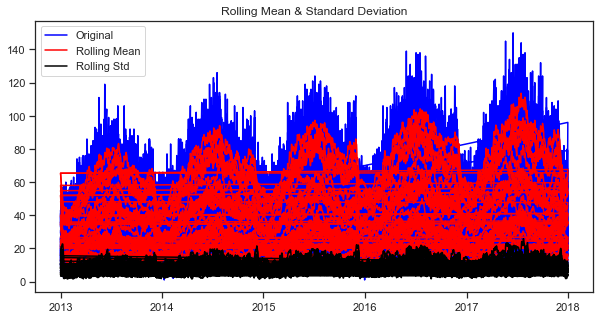

Results of Dickey Fuller Test:
Test Statistic                -7.585445e+00
p-value                        2.614162e-11
#Lags Used                     5.700000e+01
Number of Observations Used    4.994200e+04
Critical Value (1%)           -3.430481e+00
Critical Value (5%)           -2.861598e+00
Critical Value (10%)          -2.566801e+00
dtype: float64


In [22]:
test_stationarity(exponentialDecayWeightedAverage)

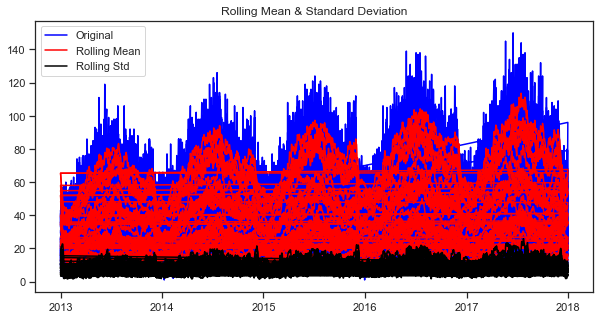

Results of Dickey Fuller Test:
Test Statistic                -7.585445e+00
p-value                        2.614162e-11
#Lags Used                     5.700000e+01
Number of Observations Used    4.994200e+04
Critical Value (1%)           -3.430481e+00
Critical Value (5%)           -2.861598e+00
Critical Value (10%)          -2.566801e+00
dtype: float64


In [44]:
datasetLogScaleMinusExponentialMovingAverage  =  indexedset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

<a id= TimeShiftTransformation > </a>
#### 5.4 Time Shift Transformation

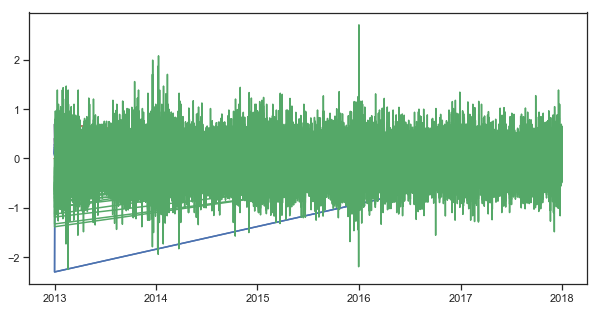

In [45]:
datasetLogDiffShifting  =  indexedset_logScale - indexedset_logScale.shift()
plt.plot(datasetLogDiffShifting)

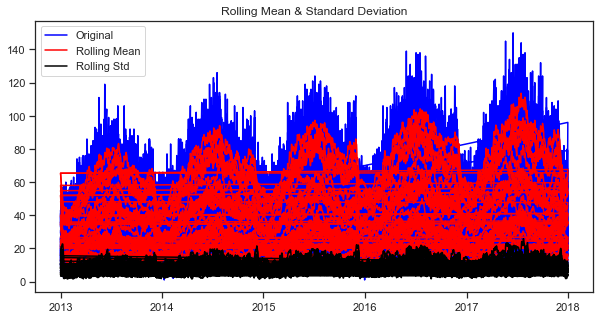

Results of Dickey Fuller Test:
Test Statistic                -7.585445e+00
p-value                        2.614162e-11
#Lags Used                     5.700000e+01
Number of Observations Used    4.994200e+04
Critical Value (1%)           -3.430481e+00
Critical Value (5%)           -2.861598e+00
Critical Value (10%)          -2.566801e+00
dtype: float64


In [46]:
datasetLogDiffShifting.dropna(inplace = True)

test_stationarity(datasetLogDiffShifting)

<a id= PlottingACF&PACF > </a>
### 6. Plotting ACF & PACF 

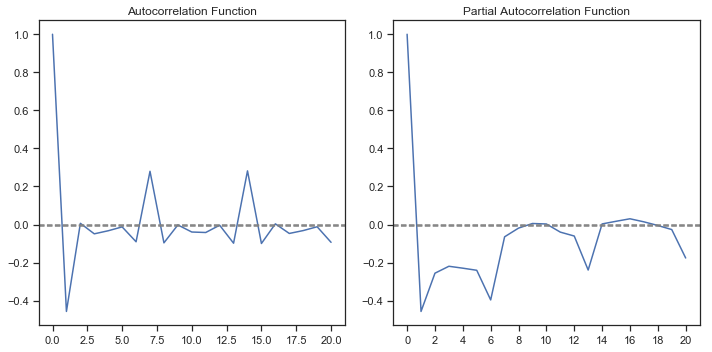

In [47]:
#ACF & PACF plots

from statsmodels.tsa.stattools import acf, pacf
#print("DataSetLog :",datasetLogDiffShifting )
lag_acf  =  acf(datasetLogDiffShifting['sales'], nlags = 20)
lag_pacf  =  pacf(datasetLogDiffShifting['sales'], nlags = 20, method = 'ols')
rcParams['figure.figsize']  =  10, 5


#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle = '--', color = 'gray')
#plt.xticks(np.arange(0,22,2))
plt.title('Autocorrelation Function')            



#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle = '--', color = 'gray')
plt.xticks(np.arange(0,22,2))
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()            

From the __ACF graph__, 
- Curve touches y = 0.0 line at x = 1. Thus, __Q  =  1__


From the __PACF graph__,
- Curve touches y = 0.0 line at x = 1. Thus, __P  =  1__

ARIMA is AR + I + MA. Before, we see an ARIMA model, let us check the results of the individual AR & MA model. Note that, these models will give a value of RSS. Lower RSS values indicate a better model.

<a id= BuildingModels > </a>
### 7. Building Models 

Let us forecaste deploying AR, ARMA and ARIMA model.

<a id= ARModel > </a>
#### 7.1 AR MODEL

- Using AR model to forecast __3 months sales__. 
- Dividing the dataset into __train and test__. Keeping 3 months data for testing the performance of our time series model.

In [48]:
datasetLogDiffShifting.head()

,store,item,sales
date,,,
2013-01-02,0.0,0.0,-0.167054
2013-01-03,0.0,0.0,0.241162
2013-01-04,0.0,0.0,-0.074108
2013-01-05,0.0,0.0,-0.262364
2013-01-06,0.0,0.0,0.182322


In [61]:
# Data Preparation

train, test = datasetLogDiffShifting[1:len(datasetLogDiffShifting)-3], datasetLogDiffShifting[len(datasetLogDiffShifting)-3:]

train.head()


date
2013-01-03    0.241162
2013-01-04   -0.074108
2013-01-05   -0.262364
2013-01-06    0.182322
2013-01-07   -0.182322
Name: sales, dtype: float64

- Deploying the autoregression model of __statsmodels library__ provided in the ar_model class.
- It automatically selects an appropriate lag value using statistical tests and trains a linear regression model.

In [59]:
from statsmodels.tsa.ar_model import AR
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

D:\Sathish\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Lag: 57
Coefficients: const        0.000184
L1.sales    -0.877577
L2.sales    -0.763488
L3.sales    -0.684617
L4.sales    -0.606875
L5.sales    -0.547896
L6.sales    -0.478640
L7.sales    -0.323430
L8.sales    -0.284226
L9.sales    -0.254453
L10.sales   -0.236595
L11.sales   -0.228824
L12.sales   -0.218125
L13.sales   -0.206270
L14.sales   -0.094869
L15.sales   -0.090272
L16.sales   -0.083235
L17.sales   -0.091010
L18.sales   -0.090501
L19.sales   -0.099971
L20.sales   -0.096645
L21.sales    0.004861
L22.sales   -0.009945
L23.sales   -0.014426
L24.sales   -0.021406
L25.sales   -0.025618
L26.sales   -0.035697
L27.sales   -0.033670
L28.sales    0.067270
L29.sales    0.063816
L30.sales    0.058592
L31.sales    0.044591
L32.sales    0.034605
L33.sales    0.036962
L34.sales    0.038593
L35.sales    0.121310
L36.sales    0.097849
L37.sales    0.076915
L38.sales    0.048488
L39.sales    0.027501
L40.sales    0.023823
L41.sales    0.020148
L42.sales    0.106682
L43.sales    0.087672
L44.sales 

- __Forecasting__ using the developed model and printing out the __3 month forecast__.

In [62]:
# make predictions
end1 = len(train)+len(test)-1
predictions = model_fit.predict(start=len(train), end=end1, dynamic=False)
for i in range(len(predictions)):
    print('Predicted=%f, Expected=%f'  % (predictions.iloc[i], test.iloc[i]))    
    

Predicted=0.340034, Expected=0.171850
Predicted=0.049033, Expected=0.489548
Predicted=0.019557, Expected=-0.195309


D:\Sathish\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


- __Model evaluation__ using Mean_squared_error

Test MSE: 0.090


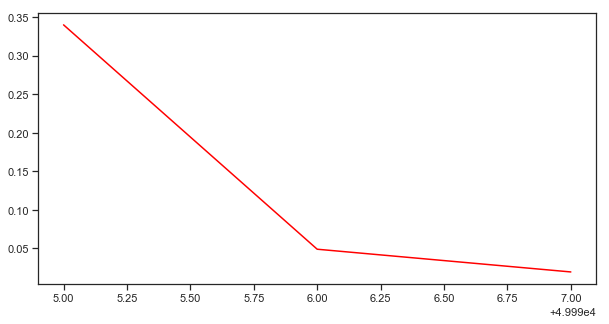

In [63]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results

pyplot.plot(predictions,color='red')
#pyplot.plot(error, color='blue')
pyplot.show()

Plotting AR model


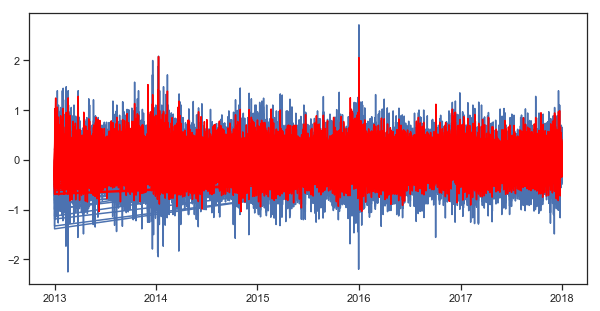

In [64]:
plt.plot(train)
plt.plot(model_fit.fittedvalues, color = 'red')
print('Plotting AR model')

<a id= ARMAModel > </a>
#### 7.2 ARMA Model

In [65]:
from statsmodels.tsa.arima_model import ARMA

model = ARMA(train,order=(3,3))
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

D:\Sathish\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Lag: 3
Coefficients: const          0.000029
ar.L1.sales    1.148481
ar.L2.sales   -0.878122
ar.L3.sales   -0.097485
ma.L1.sales   -2.097975
ma.L2.sales    2.053298
ma.L3.sales   -0.850026
dtype: float64


D:\Sathish\Anaconda\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [204]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions.iloc[i], test.iloc[i]))

predicted=0.359629, expected=0.171850
predicted=0.066945, expected=0.489548
predicted=-0.212380, expected=-0.195309


D:\Sathish\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


- Model evaluation using Mean_squared_error

Test MSE: 0.071


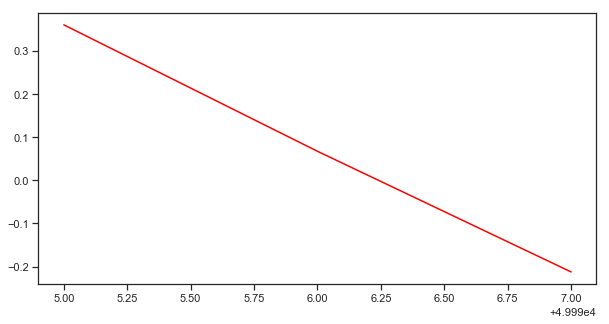

In [206]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results

#pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

Plotting ARMA model


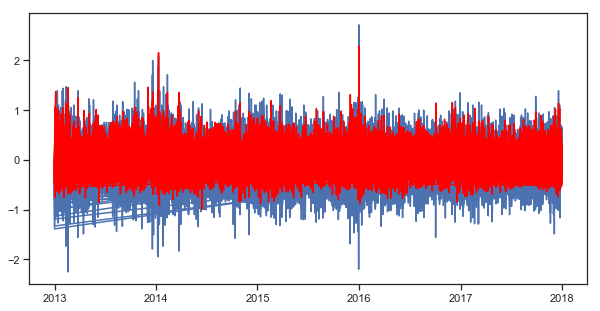

In [207]:
plt.plot(train)
plt.plot(model_fit.fittedvalues, color = 'red')
print('Plotting ARMA model')

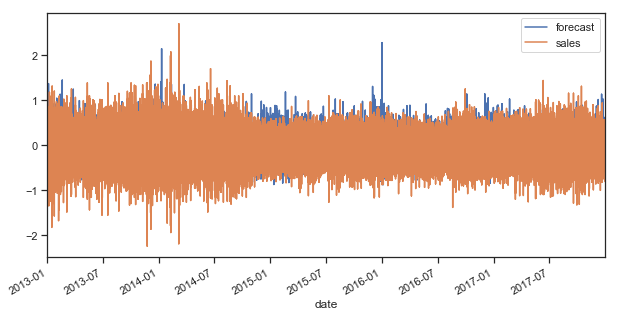

In [208]:
plot = model_fit.plot_predict()

<a name = "ARIMAModel"></a>
#### 7.3 ARIMA Model 

- Training ARIMA model with __stationary__ made dataset "datasetLogDiffShifting" using the (p,d,q) = __(2,0,2)__. 
- p and q values are chosen considering observations of ACF and PACF plots.

In [209]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(datasetLogDiffShifting,order=(2,0,2))
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 3
Coefficients: const          0.000029
ar.L1.sales    1.148481
ar.L2.sales   -0.878122
ar.L3.sales   -0.097485
ma.L1.sales   -2.097975
ma.L2.sales    2.053298
ma.L3.sales   -0.850026
dtype: float64


D:\Sathish\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


- __Model evaluation__ using Mean_squared_error

In [66]:
results_ARIMA = model.fit()

D:\Sathish\Anaconda\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [67]:
results_ARIMA.fittedvalues.head()

date
2013-01-03    0.000029
2013-01-04   -0.116765
2013-01-05   -0.016445
2013-01-06    0.151284
2013-01-07   -0.036037
dtype: float64

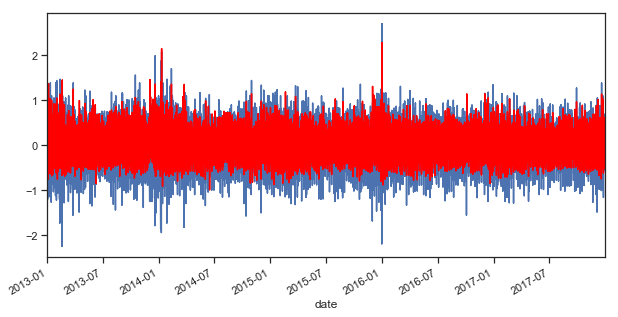

In [68]:
datasetLogDiffShifting.plot()
results_ARIMA.fittedvalues.plot(color='red')

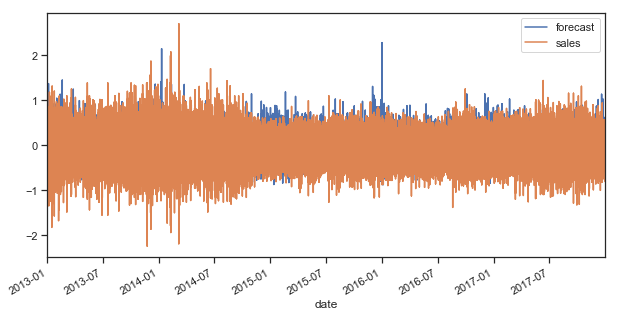

In [69]:
fitted_values = results_ARIMA.plot_predict()

<a name = "Prediction&ReverseTransformations"></a>
### 8. Prediction & Reverse transformations of fittedvalues

In [70]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

date
2013-01-03    0.000029
2013-01-04   -0.116765
2013-01-05   -0.016445
2013-01-06    0.151284
2013-01-07   -0.036037
dtype: float64

In [71]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

date
2013-01-03    0.000029
2013-01-04   -0.116736
2013-01-05   -0.133181
2013-01-06    0.018104
2013-01-07   -0.017933
dtype: float64

In [77]:
predictions_ARIMA_log = pd.Series(indexedset_logScale['sales'].iloc[:100], index=datasetLogDiffShifting.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

date
2013-01-01    0.347891
2013-01-01   -1.193948
2013-01-01   -0.271516
2013-01-01    0.101033
2013-01-01    2.424028
dtype: float64

In [78]:
reverted_back_prediction = pd.DataFrame(np.exp(predictions_ARIMA_log))
reverted_back_prediction.head()

,0
date,
2013-01-01,1.416078
2013-01-01,0.303023
2013-01-01,0.762223
2013-01-01,1.106313
2013-01-01,11.291254


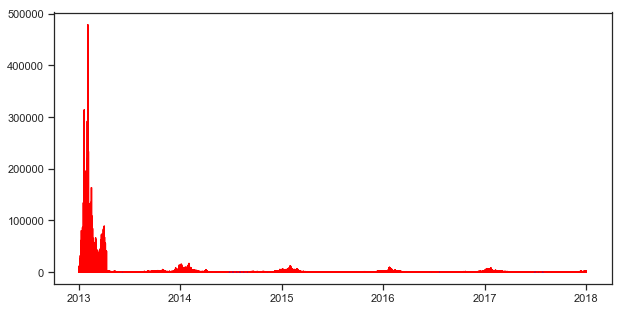

In [91]:
from matplotlib import pyplot
pyplot.plot(datasetLogDiffShifting, color='blue')
pyplot.plot(reverted_back_prediction, color='red')
pyplot.show()

In [112]:
#indexedset_logScale['sales'] = ['Sales in logscale']
reverted_back_prediction.columns = ['ARIMA Predicted Sales']
datasetLogDiffShifting.columns = ['Sales after log diff shifting']

In [117]:
df = pd.concat([indexedset,indexedset_logScale,datasetLogDiffShifting,reverted_back_prediction], axis=1, sort=False)
df.tail()

TypeError: cannot concatenate object of type "<class 'list'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

In [122]:
print(indexedset.head())

            store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10


### Forecasting the Store Sales for next 3 Months 

- We have 3(existing data of 3 months) data points. <br/>
To forecast additional 3 month data points or __6 months__.
- Using plot_predict method

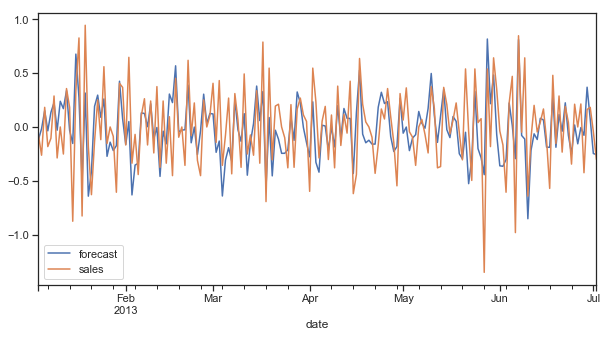

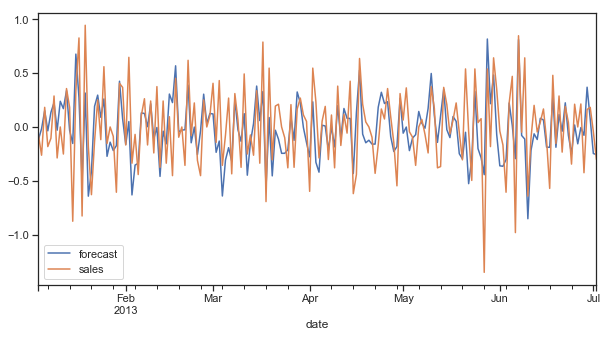

In [124]:
results_ARIMA.plot_predict(1,180) 

In [152]:
six_mon_forecast = results_ARIMA.predict(start= 1,end = 180)

- Prediction & Reverse transformations of 6 months forecast

In [144]:
predictions_ARIMA_diff = pd.Series(six_mon_forecast, copy=True)
predictions_ARIMA_diff.head()

date
2013-01-04   -0.116765
2013-01-05   -0.016445
2013-01-06    0.151284
2013-01-07   -0.036037
2013-01-08    0.135653
dtype: float64

In [145]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

date
2013-01-04   -0.116765
2013-01-05   -0.133210
2013-01-06    0.018075
2013-01-07   -0.017962
2013-01-08    0.117690
dtype: float64

In [149]:
predictions_ARIMA_log = pd.Series(indexedset_logScale['sales'].iloc[-1], index=predictions_ARIMA_diff.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

date
2013-01-04    3.815061
2013-01-05    3.798616
2013-01-06    3.949900
2013-01-07    3.913863
2013-01-08    4.049516
dtype: float64

In [150]:
reverted_back_prediction = pd.DataFrame(np.exp(predictions_ARIMA_log))
reverted_back_prediction.head()

,0
date,
2013-01-04,45.379517
2013-01-05,44.639365
2013-01-06,51.930182
2013-01-07,50.092092
2013-01-08,57.369689


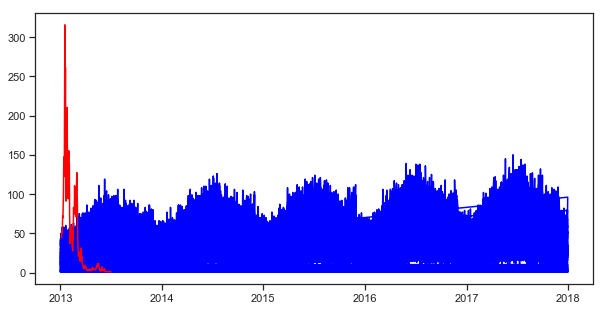

In [155]:
from matplotlib import pyplot
pyplot.plot(indexedset, color='blue')
pyplot.plot(reverted_back_prediction, color='red')
pyplot.show()

<a name = "con"></a>
### 9. Conclusion

- Using ARIMA model our forcast and actual almost in line with the predictions